In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


binary	brain  breast  er  lung  masked  mean  mice  mode


In [12]:
! cd drive/MyDrive/AUTOMATION/DarthImputer\(AutomationProject\)/data/
! wget -P binary/ https://archive.ics.uci.edu/static/public/244/fertility.zip
! unzip -q binary/fertility.zip -d binary/fertility_data

--2024-04-25 18:48:16--  https://archive.ics.uci.edu/static/public/244/fertility.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘binary/fertility.zip’

fertility.zip           [ <=>                ]   3.11K  --.-KB/s    in 0s      

2024-04-25 18:48:16 (456 MB/s) - ‘binary/fertility.zip’ saved [3185]



In [2]:
import sys
def GetRoot(user = None):
    '''
    Deterimines what the root path is for google collab.
    Inputs:
    user (str): Name of the person using this notebook.

    Output:
    (str) root path
    '''
    if user.lower() == 'jackie':
        root = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)'
    elif user.lower() == 'thomas':
        root = '/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)'
    elif user.lower() == 'gabe':
        root = '/content/drive/MyDrive/DarthImputer(AutomationProject)'
    else:
        raise Exception("Ya fucked up son. Who are you?")

    return root

root = GetRoot('jackie')
sys.path.append(f'{root}/src')

In [3]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import helpers
import basic_impute
import mice
import ImputationPipeline

In [121]:
importlib.reload(mice)
importlib.reload(helpers)
importlib.reload(basic_impute)
importlib.reload(ImputationPipeline)

<module 'ImputationPipeline' from '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/src/ImputationPipeline.py'>

In [122]:
def Simple_Methods_Imputation(data, method, seed):
  '''
  Args:
  - data,
  - method,
  - seed
  Returns:
  -
  '''
  if method.lower() == 'mode':
    imputated_data = basic_impute.Imputation_Mode(data, seed)
  elif method.lower() == 'mean':
    imputated_data = basic_impute.Imputation_Mean(data, seed)


In [123]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Base model

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import os
from sklearn.metrics import mean_squared_error as mse

In [128]:
class Dataset():
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def len(self):
    return len(self.X)

  def split_data(self, test_portion, seed=174):
    np.random.seed(seed)
    n = self.X.shape[0]
    test_idx = np.random.choice(np.arange(n), size = int(test_portion*n), replace=False)
    train_idx = np.setdiff1d(np.arange(n), test_idx)
    return train_idx, test_idx

  def get_split(self, test_portion, seed=174):
    train_idx, test_idx = self.split_data(test_portion, seed)
    train_dataset = Dataset(self.X[train_idx], self.y[train_idx])
    test_dataset = Dataset(self.X[test_idx], self.y[test_idx])

    return train_dataset, test_dataset

In [129]:
def BaselineModel(traindata, testdata):

    Xtrain, ytrain = traindata.X, traindata.y
    Xtest, ytest = testdata.X, testdata.y
    model = LogisticRegression(penalty='l1', random_state=42, solver='saga', multi_class='multinomial')
    model.fit(Xtrain, ytrain)
    preds = model.predict(Xtest)
    acc = accuracy_score(preds, ytest)

    return acc

In [130]:
full_X = np.load('/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/brain/brain_5000.npy')
full_y = np.load('/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/brain/labels.npy')

In [131]:
train_idx, test_idx = Dataset(full_X, full_y).split_data(test_portion=30/130, seed=174)
np.save(f'{root}/data/brain/train_indices.npy', train_idx)
np.save(f'{root}/data/brain/test_indices.npy', test_idx)

In [132]:
train_dataset, test_dataset = Dataset(full_X, full_y).get_split(test_portion=30/130, seed=174)

# Create missing data

In [127]:
dataset = 'brain'
i = 1
d = 50
for seed in [0,1,2,3,4]:
  # for prop in np.arange(0.05, 0.51, 0.05):
    prop = 0.9
    print(f'{i}/{len([0,1,2,3,4])}')
    i += 1
    masked_data = helpers.Implement_Random_Masking(train_dataset.X, 0.9, prop, seed)
    name = f'{dataset}_prow0.9_{prop:0.2f}_{seed}.npy'
    np.save(f'{root}/data/masked/{dataset}/{name}', masked_data)

1/5
2/5
3/5
4/5
5/5


# Full dataset training

In [14]:
full_acc = BaselineModel(train_dataset, test_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
full_acc

0.9333333333333333

# Mean method

In [16]:
train_y = full_y[train_idx]

In [ ]:
masked_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/masked/brain'
save_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/mean/brain_5000'
mean_acc = {}
mean_loss = []
for i, file in enumerate(os.listdir(masked_path)):
  print(f'{i+1}/{len(os.listdir(masked_path))}')
  data = np.load(f'{masked_path}/{file}')
  imputated_data = basic_impute.Imputation_Mean(data, seed=42)
  loss = mse(imputated_data, full_X[train_idx])
  mean_loss.append(loss)
  np.save(f'{save_path}/{file}.npy', imputated_data)
  train_data = Dataset(X=imputated_data, y= train_y)
  curr_acc = BaselineModel(train_data, test_dataset)
  mean_acc[file] = curr_acc
np.save(f'{save_path}/mean_loss.npy', mean_loss)

In [ ]:
mean_acc

In [133]:
masked_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/masked/brain'
save_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/mean/brain_5000'
mean90 = []
mean_acc90 = []
for i, file in enumerate(os.listdir(masked_path)):
  if file.split('_')[1] == 'prow0.9':
    print(f'{i+1}/{len(os.listdir(masked_path))}')
    data = np.load(f'{masked_path}/{file}')
    imputated_data = basic_impute.Imputation_Mean(data, seed=42)
    loss = mse(imputated_data, full_X[train_idx])
    # mean_loss.append(loss)
    mean90.append(loss)
    np.save(f'{save_path}/{file}.npy', imputated_data)
    train_data = Dataset(X=imputated_data, y= train_y)
    curr_acc = BaselineModel(train_data, test_dataset)
    mean_acc90.append(curr_acc)
    # np.save(f'{save_path}/mean_loss.npy', mean_loss)

56/60
57/60
58/60
59/60
60/60


# Mode

In [ ]:
masked_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/masked/brain'
save_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/mode/brain_5000'
mode_acc = {}
# mode_loss = []
for i, file in enumerate(os.listdir(masked_path)):
  print(f'{i+1}/{len(os.listdir(masked_path))}')
  data = np.load(f'{masked_path}/{file}')
  imputated_data = basic_impute.Imputation_Mode(data, seed=42)
  # np.save(f'{save_path}/{file}.npy', imputated_data)
  # curr_loss = mse(imputated_data, full_X[train_idx])
  # mode_loss.append(curr_loss)
  train_data = Dataset(X=imputated_data, y= train_y)
  curr_acc = BaselineModel(train_data, test_dataset)
  mode_acc[file] = curr_acc
# np.save(f'{save_path}/mode_loss.npy', mode_loss)

In [ ]:
masked_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/masked/brain'
save_path = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)/data/mode/brain_5000'
mode_acc = {}
# mode_loss = []
for i, file in enumerate(os.listdir(masked_path)):
  print(f'{i+1}/{len(os.listdir(masked_path))}')
  data = np.load(f'{masked_path}/{file}')
  imputated_data = basic_impute.Imputation_Mode(data, seed=42)
  # np.save(f'{save_path}/{file}.npy', imputated_data)
  # curr_loss = mse(imputated_data, full_X[train_idx])
  # mode_loss.append(curr_loss)
  train_data = Dataset(X=imputated_data, y= train_y)
  curr_acc = BaselineModel(train_data, test_dataset)
  mode_acc[file] = curr_acc
# np.save(f'{save_path}/mode_loss.npy', mode_loss)

# Plot

In [19]:
import matplotlib.pyplot as plt

In [74]:
mean_mean_acc = [np.mean(list(mean_acc.values())[i:i+5]) for i in range(0,50, 5)]
mean_mode_acc = [np.mean(list(mode_acc.values())[i:i+5]) for i in range(0,50, 5)]

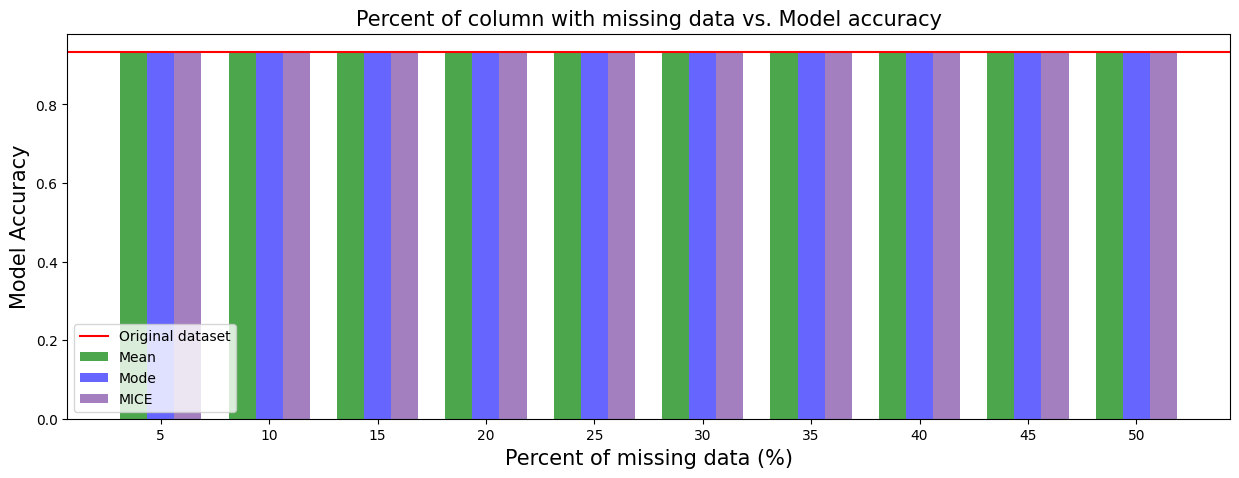

In [115]:
bar_width = 0.25

plt.figure(figsize=(15,5))
plt.bar(np.arange(len(mean_mean_acc)), mean_mean_acc, width=bar_width, color='g', alpha=0.7, label='Mean')
plt.bar(np.arange(len(mean_mode_acc))+bar_width, mean_mode_acc, width=bar_width, color='b', alpha=0.6, label='Mode')
plt.bar(np.arange(len(mean_mode_acc))+2*bar_width, mean_mode_acc, width=bar_width, color='indigo', alpha=0.5, label='MICE')

plt.ylabel("Model Accuracy", fontsize=15)
plt.xlabel("Percent of missing data (%)", fontsize=15)
plt.xticks(ticks=np.arange(len(mean_mean_acc))+bar_width, labels=np.arange(5, 51, 5), fontsize=10)

plt.axhline(full_acc, color='r', label='Original dataset')

plt.legend()
plt.title('Percent of column with missing data vs. Model accuracy', fontsize=15)
plt.show()